In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,17.261949,level_366,level_33,level_398,level_283,level_59,level_42,level_348,level_277,level_310,...,level_142,level_464,level_361,level_127,level_255,level_214,level_196,level_272,level_228,level_361
1,-22.869820,level_323,level_85,level_111,level_32,level_338,level_118,level_173,level_154,level_482,...,level_241,level_337,level_3,level_200,level_329,level_6,level_362,level_39,level_443,level_209
2,-11.247903,level_311,level_318,level_261,level_394,level_276,level_83,level_169,level_268,level_388,...,level_146,level_130,level_462,level_287,level_244,level_269,level_97,level_56,level_106,level_15
3,5.602966,level_333,level_458,level_477,level_315,level_282,level_47,level_265,level_227,level_24,...,level_434,level_188,level_211,level_142,level_301,level_39,level_404,level_479,level_373,level_165
4,8.250238,level_403,level_284,level_133,level_143,level_68,level_110,level_294,level_143,level_9,...,level_361,level_57,level_417,level_275,level_387,level_32,level_365,level_459,level_34,level_468


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,17.320071,5.726887,-1.579630,13.524167,19.578042,6.542478,-6.249088,8.835440,8.194376,0.620533,...,4.395462,3.453934,-6.789293,-0.230312,4.151739,5.681573,2.892822,6.464729,5.684302,-2.127705
1,8.473432,-7.737977,-22.034276,1.970700,-5.045257,-4.554694,-6.852411,-0.260574,-3.025272,-5.614215,...,-12.854892,-10.783811,4.298976,-6.127931,1.787417,6.043383,-2.169563,-0.837315,4.790945,-3.087917
2,-0.726521,-13.881611,2.897994,-8.951712,6.764953,0.770874,5.851522,-11.422254,-5.767155,-5.199606,...,3.636039,-4.792955,-3.245247,6.804974,0.532277,6.640911,9.887481,-5.520230,2.786579,-1.882632
3,19.691432,11.368537,11.392070,3.651666,6.306504,19.062499,-5.738073,1.604141,10.422044,-1.668876,...,-4.230099,-2.869930,2.456139,1.380489,2.231455,7.287824,9.556461,0.063703,-3.363299,16.122232
4,-6.465325,1.075282,2.058551,-11.240019,-0.031883,-7.920563,2.692637,5.689701,-2.177734,-6.609134,...,2.453704,-5.987132,13.974615,-1.445140,-1.725057,0.810000,-3.270547,-3.848934,-6.034566,-5.123948


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,0.000000,3.235910,-0.852096,10.105896,10.982528,2.155940,-3.808928,7.025106,6.180097,0.442260,...,1.716503,0.909068,-3.587934,-0.098429,1.966590,4.824079,1.707465,1.488169,4.326758,-1.528827
1,2.346695,-5.074386,-15.678099,1.282581,-1.753386,-3.067990,-4.386120,-0.169243,-1.756567,-3.896916,...,-8.454664,-5.154812,1.955384,-4.005079,0.754353,2.050228,-1.591036,-0.569386,1.992096,-1.759855
2,-0.271354,-11.501626,1.794834,-7.264518,4.472557,0.616014,2.684290,-2.589909,-1.961658,-4.591823,...,1.828283,-1.418643,-2.277494,4.848998,0.234365,4.430729,3.461846,-3.232355,1.428428,-1.262318
3,16.067969,8.978773,8.929047,2.859450,4.928439,15.174078,-3.314523,1.144108,7.537951,-0.824358,...,-1.593222,-2.038111,0.714052,0.691371,0.971407,2.229152,5.297728,0.026429,-1.565041,10.150574
4,-5.469036,0.752243,0.863211,-10.620555,-0.017352,-5.399827,1.672661,3.801999,-1.578024,-4.993931,...,0.238257,-2.964090,6.967082,-0.947370,-1.002862,0.445340,-2.474459,-2.431095,-3.379256,-3.292707


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,0.000000,0.157460,0.000000e+00,8.989524,6.136171,0.000000,-7.811864,6.223152,7.141914,-2.139649,...,0.000000e+00,-0.046624,-9.528808,3.022108,0.292894,2.822537,1.940296,4.166646e-01,1.192693,-5.556235
1,5.703957,-2.112992,-1.454431e+01,6.506803,0.000000,0.255385,1.561364,0.402003,-4.942548,-2.070637,...,-4.956337e+00,-0.884127,5.182227,-2.883508,7.234314,20.126619,-2.041392,-2.569659e-02,0.000000,0.148055
2,0.668950,-9.636595,3.205252e+00,-7.035136,3.002474,1.816481,0.000000,-0.984936,-0.432503,-6.101421,...,2.218924e+00,-0.303087,0.060696,10.078164,-0.971408,6.199541,5.498759,2.775558e-17,6.978687,-0.756400
3,0.000000,7.374654,7.317377e+00,0.811988,5.566403,22.955582,-11.742703,4.202225,11.317328,-4.041292,...,-4.939055e+00,-0.527438,-0.559309,-1.142606,-0.582710,0.520513,6.462592,-2.477269e+00,-2.289290,0.000000
4,-2.699626,4.803980,5.551115e-17,-8.755291,-1.561342,-2.803472,4.135146,-2.945514,0.866288,-5.220217,...,-5.551115e-17,-2.226395,9.053592,0.801389,2.483373,4.233860,1.009193,-5.977111e+00,-2.249950,-10.239468


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.529495,0.503608,0.161188,0.158317,False
1,var_1_impact_code,0.524086,0.496389,0.136143,0.167458,False
2,var_2_impact_code,0.536114,0.510947,0.165000,0.174264,False
3,var_3_impact_code,0.528320,0.494688,0.118316,0.135535,False
4,var_4_impact_code,0.523477,0.495566,0.131917,0.168624,False
5,var_5_impact_code,0.544084,0.520650,0.200164,0.202102,False
6,var_6_impact_code,0.510071,0.480347,0.109409,0.170746,False
7,var_7_impact_code,0.511942,0.484997,0.126399,0.163664,False
8,var_8_impact_code,0.522594,0.492264,0.149728,0.162433,False
9,var_9_impact_code,0.532989,0.509418,0.170135,0.198233,False


(0.783850341922763, 4.341562822252068e-24)


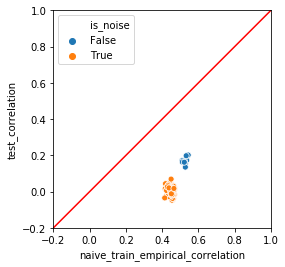

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.7988390515115612, 1.3819598352483905e-25)


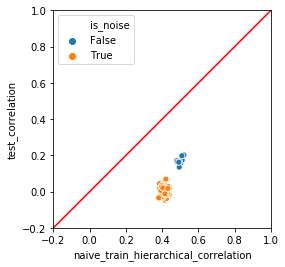

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.771935994054564, 5.562389121352872e-23)


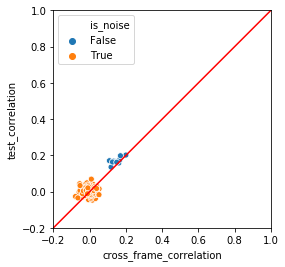

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,-0.003408,0.864322,110.0,False
106,noise_96_impact_code,noise_96,impact_code,True,True,-0.006433,0.747072,110.0,False
107,noise_97_impact_code,noise_97,impact_code,True,True,-0.009512,0.633443,110.0,False
108,noise_98_impact_code,noise_98,impact_code,True,True,-0.012139,0.542781,110.0,False
109,noise_99_impact_code,noise_99,impact_code,True,True,0.038544,0.053220,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_33_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,5.602966,-7.151076,-0.570634,-2.379726,-2.314367
1,8.250238,10.479139,7.714301,1.992727,2.822723
2,-11.870930,-0.181781,-1.012481,1.776068,1.446694
3,-6.898813,-2.125846,1.329758,1.141126,0.614278
4,-5.477608,-7.078046,-6.404708,1.429594,1.204424


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.135124409668476


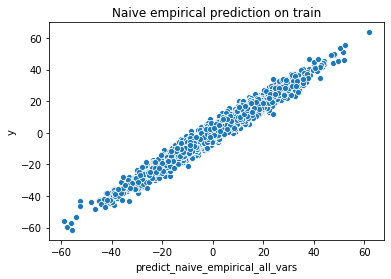

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.644677708419108


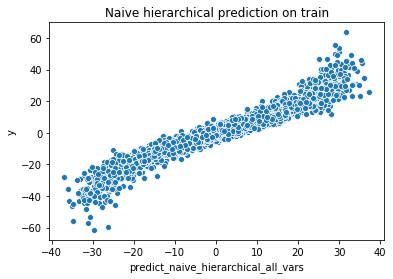

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.037843961203677


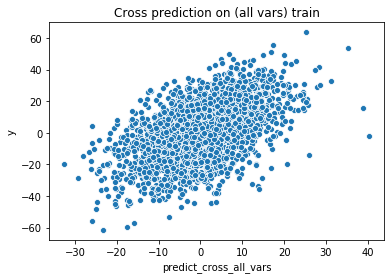

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.537761935234036


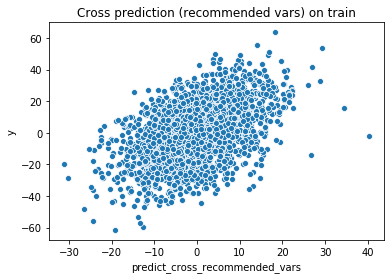

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.442402373270305


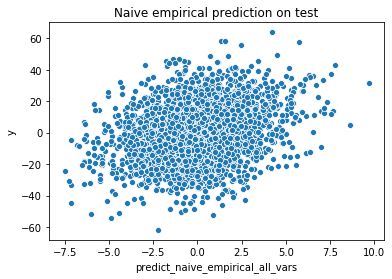

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.060717090731934


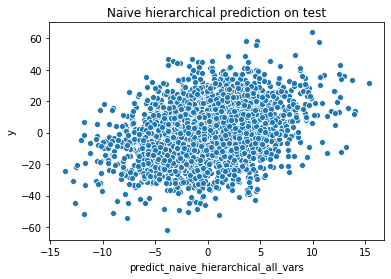

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.782673403528737


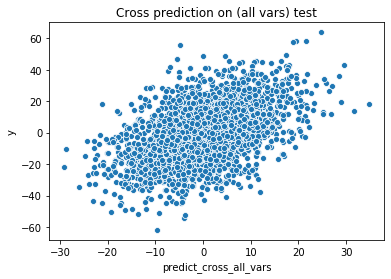

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.369090555619742


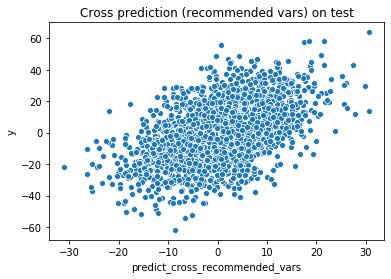

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     677.7
Date:                Sat, 17 Aug 2019   Prob (F-statistic):               0.00
Time:                        10:53:35   Log-Likelihood:                -6445.0
No. Observations:                2516   AIC:                         1.311e+04
Df Residuals:                    2405   BIC:                         1.376e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0581      0.064     -0.909      0.363      -0.183       0.067
var_0_impact_code        0.0447      0.008      5.418      0.000       0.029       0.061
var_1_impact_code        0.0573      0.008      6.990      0.000       0.041       0.073
var_2_impact_code        0.0632      0.008      7.839      0.000       0.047       0.079
var_3_impact_code        0.0671      0.008      8.217      0.000       0.051       0.083
var_4_impact_code        0.0630      0.008      7.648      0.000       0.047       0.079
var_5_impact_code        0.0712      0.008      8.874      0.000       0.055       0.087
var_6_impact_code        0.0467      0.008      5.590      0.000       0.030       0.063
var_7_impact_code        0.0579      0.008      6.934      0.000       0.042       0.074
var_8_impact_code        0.0630      0.008      7.624      0.000       0.047       0.079
var_9_impact_code        0.0528      0.008      6.469      0.000       0.037       0.069
noise_0_impact_code      0.0449      0.009      4.889      0.000       0.027       0.063
noise_1_impact_code      0.0356      0.009      4.016      0.000       0.018       0.053
noise_2_impact_code      0.0341      0.009      3.714      0.000       0.016       0.052
noise_3_impact_code      0.0253      0.009      2.726      0.006       0.007       0.044
noise_4_impact_code      0.0487      0.009      5.351      0.000       0.031       0.067
noise_5_impact_code      0.0297      0.009      3.304      0.001       0.012       0.047
noise_6_impact_code      0.0186      0.009      1.967      0.049    6.01e-05       0.037
noise_7_impact_code      0.0377      0.009      4.007      0.000       0.019       0.056
noise_8_impact_code      0.0277      0.009      2.924      0.003       0.009       0.046
noise_9_impact_code      0.0317      0.009      3.506      0.000       0.014       0.049
noise_10_impact_code     0.0247      0.009      2.684      0.007       0.007       0.043
noise_11_impact_code     0.0284      0.009      3.124      0.002       0.011       0.046
noise_12_impact_code     0.0446      0.009      4.838      0.000       0.027       0.063
noise_13_impact_code     0.0343      0.009      3.739      0.000       0.016       0.052
noise_14_impact_code     0.0551      0.009      6.024      0.000       0.037       0.073
noise_15_impact_code     0.0538      0.009      5.986      0.000       0.036       0.071
noise_16_impact_code     0.0420      0.009      4.473      0.000       0.024       0.060
noise_17_impact_code     0.0526      0.010      5.530      0.000       0.034       0.071
noise_18_impact_code     0.0416      0.009      4.557      0.000       0.024       0.060
noise_19_impact_code     0.0331      0.009      3.635      0.000       0.015       0.051
noise_20_impact_code     0.0578      0.009      6.448    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9687460372671172

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.05994971334505994

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     8.542
Date:                Sat, 17 Aug 2019   Prob (F-statistic):          3.38e-107
Time:                        10:53:36   Log-Likelihood:                -10390.
No. Observations:                2516   AIC:                         2.100e+04
Df Residuals:                    2405   BIC:                         2.165e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0812      0.312      0.260      0.795      -0.531       0.693
var_0_impact_code        0.4654      0.048      9.677      0.000       0.371       0.560
var_1_impact_code        0.4028      0.048      8.456      0.000       0.309       0.496
var_2_impact_code        0.4130      0.047      8.719      0.000       0.320       0.506
var_3_impact_code        0.3557      0.048      7.410      0.000       0.262       0.450
var_4_impact_code        0.3659      0.048      7.669      0.000       0.272       0.459
var_5_impact_code        0.5054      0.047     10.829      0.000       0.414       0.597
var_6_impact_code        0.3049      0.049      6.182      0.000       0.208       0.402
var_7_impact_code        0.3616      0.048      7.506      0.000       0.267       0.456
var_8_impact_code        0.4254      0.048      8.793      0.000       0.331       0.520
var_9_impact_code        0.4355      0.046      9.563      0.000       0.346       0.525
noise_0_impact_code      0.0387      0.056      0.696      0.487      -0.070       0.148
noise_1_impact_code      0.1206      0.054      2.238      0.025       0.015       0.226
noise_2_impact_code      0.0899      0.058      1.545      0.122      -0.024       0.204
noise_3_impact_code      0.0454      0.060      0.759      0.448      -0.072       0.163
noise_4_impact_code      0.0837      0.057      1.464      0.143      -0.028       0.196
noise_5_impact_code      0.0661      0.054      1.234      0.217      -0.039       0.171
noise_6_impact_code     -0.0837      0.055     -1.517      0.129      -0.192       0.024
noise_7_impact_code     -0.0922      0.058     -1.596      0.111      -0.205       0.021
noise_8_impact_code     -0.1232      0.060     -2.067      0.039      -0.240      -0.006
noise_9_impact_code     -0.0880      0.058     -1.527      0.127      -0.201       0.025
noise_10_impact_code    -0.0154      0.057     -0.269      0.788      -0.128       0.097
noise_11_impact_code    -0.0188      0.055     -0.339      0.735      -0.127       0.090
noise_12_impact_code    -0.0414      0.056     -0.736      0.462      -0.152       0.069
noise_13_impact_code     0.0386      0.055      0.702      0.483      -0.069       0.146
noise_14_impact_code     0.0979      0.058      1.696      0.090      -0.015       0.211
noise_15_impact_code     0.0116      0.055      0.209      0.835      -0.097       0.120
noise_16_impact_code    -0.1413      0.061     -2.303      0.021      -0.262      -0.021
noise_17_impact_code    -0.0542      0.060     -0.900      0.368      -0.172       0.064
noise_18_impact_code    -0.0556      0.061     -0.908      0.364      -0.176       0.064
noise_19_impact_code     0.0023      0.055      0.041      0.967      -0.106       0.111
noise_20_impact_code     0.0973      0.057      1.713    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.2809374354530154

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.23033874666547793

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     68.89
Date:                Sat, 17 Aug 2019   Prob (F-statistic):          4.10e-135
Time:                        10:53:36   Log-Likelihood:                -10472.
No. Observations:                2516   AIC:                         2.097e+04
Df Residuals:                    2504   BIC:                         2.104e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1273      0.311     -0.410      0.682      -0.737       0.482
var_0_impact_code        0.4786      0.048     10.065      0.000       0.385       0.572
var_1_impact_code        0.4112      0.047      8.660      0.000       0.318       0.504
var_2_impact_code        0.4260      0.047      9.078      0.000       0.334       0.518
var_3_impact_code        0.3661      0.048      7.691      0.000       0.273       0.459
var_4_impact_code        0.3489      0.047      7.371      0.000       0.256       0.442
var_5_impact_code        0.5119      0.046     11.104      0.000       0.422       0.602
var_6_impact_code        0.3283      0.049      6.699      0.000       0.232       0.424
var_7_impact_code        0.3570      0.048      7.491      0.000       0.264       0.450
var_8_impact_code        0.4478      0.048      9.333      0.000       0.354       0.542
var_9_impact_code        0.4499      0.045      9.952      0.000       0.361       0.539
noise_33_impact_code     0.0568      0.056      1.008      0.314      -0.054       0.167
==============================================================================
Omnibus:                        6.328   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                5.687
Skew:                          -0.064   Prob(JB):                       0.0582
Kurtosis:                       2.805   Cond. No.                         7.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.2323337328652617

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.2701479647409576